In [1]:
!pip install gensim numpy scikit-learn matplotlib seaborn

In [2]:
# -*- coding: utf-8 -*-
# Ячейка 1: Установка и импорт библиотек

# Устанавливаем необходимые версии библиотек, если требуется
# !pip install gensim==4.1.2 numpy==1.21.5 scikit-learn==1.0.2 matplotlib==3.5.1 seaborn==0.11.2

import gensim
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity  # Импортируем функцию для вычисления сходства
import warnings

# Игнорируем предупреждения для чистоты вывода
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

print("Библиотеки успешно импортированы.")

Библиотеки успешно импортированы.


In [3]:
# Ячейка 2: Загрузка моделей эмбеддингов
# Этот процесс может занять несколько минут, так как модели загружаются из сети.

classical_model_url = 'https://embeddings.lila-erc.eu/samples/download/aligned/OperaLatina.vec.txt'
aquinas_model_url = 'https://embeddings.lila-erc.eu/samples/download/aligned/OperaMaiora.vec.txt'

try:
    print("Загрузка модели классической латыни (Opera Latina)...")
    classical_model = KeyedVectors.load_word2vec_format(classical_model_url, binary=False)
    print(f"Модель классической латыни успешно загружена. Размер словаря: {len(classical_model.key_to_index)} слов.")
except Exception as e:
    print(f"Ошибка при загрузке модели классической латыни: {e}")
    classical_model = None

try:
    print("\nЗагрузка модели Фомы Аквинского (Opera Maiora)...")
    aquinas_model = KeyedVectors.load_word2vec_format(aquinas_model_url, binary=False)
    print(f"Модель Фомы Аквинского успешно загружена. Размер словаря: {len(aquinas_model.key_to_index)} слов.")
except Exception as e:
    print(f"Ошибка при загрузке модели Фомы Аквинского: {e}")
    aquinas_model = None

Загрузка модели классической латыни (Opera Latina)...
Модель классической латыни успешно загружена. Размер словаря: 14101 слов.

Загрузка модели Фомы Аквинского (Opera Maiora)...
Модель Фомы Аквинского успешно загружена. Размер словаря: 14101 слов.


In [4]:
# Ячейка 3: Определение анализируемой лексики

# Основная группа слов, выражающих понятие "народ"
main_words = ['populus', 'plebs', 'gens', 'natio', 'uulgus']

# Контекстуально-контрольная группа ("семантические якоря")
context_words = {
    'Политика (Рим)': ['ciuitas', 'ciuis', 'patricius'],
    'Родство': ['genus', 'stirps', 'familia'],
    'Власть (Средневековье)': ['regnum', 'rex', 'lex'],
    'Религия': ['fides', 'ecclesia', 'christianus'],
    'Прочее': ['lingua']
}

# Собираем все слова в один список для извлечения векторов
all_words = main_words + [word for sublist in context_words.values() for word in sublist]

print("Списки анализируемой лексики определены.")

Списки анализируемой лексики определены.


In [6]:
# Ячейка 4: Количественный анализ семантического сдвига

def calculate_semantic_shift(word, model1, model2):
    """Вычисляет косинусное сходство для одного слова между двумя моделями."""
    if word in model1 and word in model2:
        vec1 = model1[word]
        vec2 = model2[word]
        # sklearn.metrics.pairwise.cosine_similarity ожидает 2D-массивы
        return cosine_similarity([vec1], [vec2])[0][0]
    return None

if classical_model and aquinas_model:
    print("\n--- Количественный анализ семантического сдвига ---")
    print("Вычисление косинусного сходства для векторов одних и тех же слов в двух моделях:")
    print("-" * 45)
    print(f"{'Слово':<15} | {'Косинусное сходство':<20}")
    print("-" * 45)

    shift_results = {}
    for word in main_words:
        similarity = calculate_semantic_shift(word, classical_model, aquinas_model)
        if similarity is not None:
            shift_results[word] = similarity
            print(f"{word:<15} | {similarity:<20.4f}")
    print("-" * 45)
else:
    print("\nПропускаем количественный анализ из-за ошибки загрузки моделей.")


--- Количественный анализ семантического сдвига ---
Вычисление косинусного сходства для векторов одних и тех же слов в двух моделях:
---------------------------------------------
Слово           | Косинусное сходство 
---------------------------------------------
populus         | -0.1447             
plebs           | -0.1036             
gens            | 0.1090              
natio           | -0.0137             
uulgus          | 0.0187              
---------------------------------------------


In [7]:
# Ячейка 5: Подготовка данных для визуализации

def get_vectors_from_model(model, words):
    """Извлекает векторы для списка слов из модели, пропуская отсутствующие."""
    vectors, valid_words = [], []
    for word in words:
        if word in model.key_to_index:
            vectors.append(model[word])
            valid_words.append(word)
        else:
            print(f"Предупреждение: Слово '{word}' отсутствует в словаре модели.")
    return np.array(vectors), valid_words

# Извлекаем векторы и слова, которые реально есть в обеих моделях
if classical_model and aquinas_model:
    vectors_classical, words_classical = get_vectors_from_model(classical_model, all_words)
    vectors_aquinas, words_aquinas = get_vectors_from_model(aquinas_model, all_words)

    # Применяем PCA для снижения размерности до 2D
    # Важно: PCA применяется к каждой модели ОТДЕЛЬНО, чтобы сохранить
    # внутреннюю геометрию каждого семантического пространства.
    pca_classical = PCA(n_components=2, random_state=42)
    vectors_classical_2d = pca_classical.fit_transform(vectors_classical)

    pca_aquinas = PCA(n_components=2, random_state=42)
    vectors_aquinas_2d = pca_aquinas.fit_transform(vectors_aquinas)

    print("\nДанные для визуализации подготовлены.")
else:
    print("\nПропускаем подготовку данных из-за ошибки загрузки моделей.")


Данные для визуализации подготовлены.


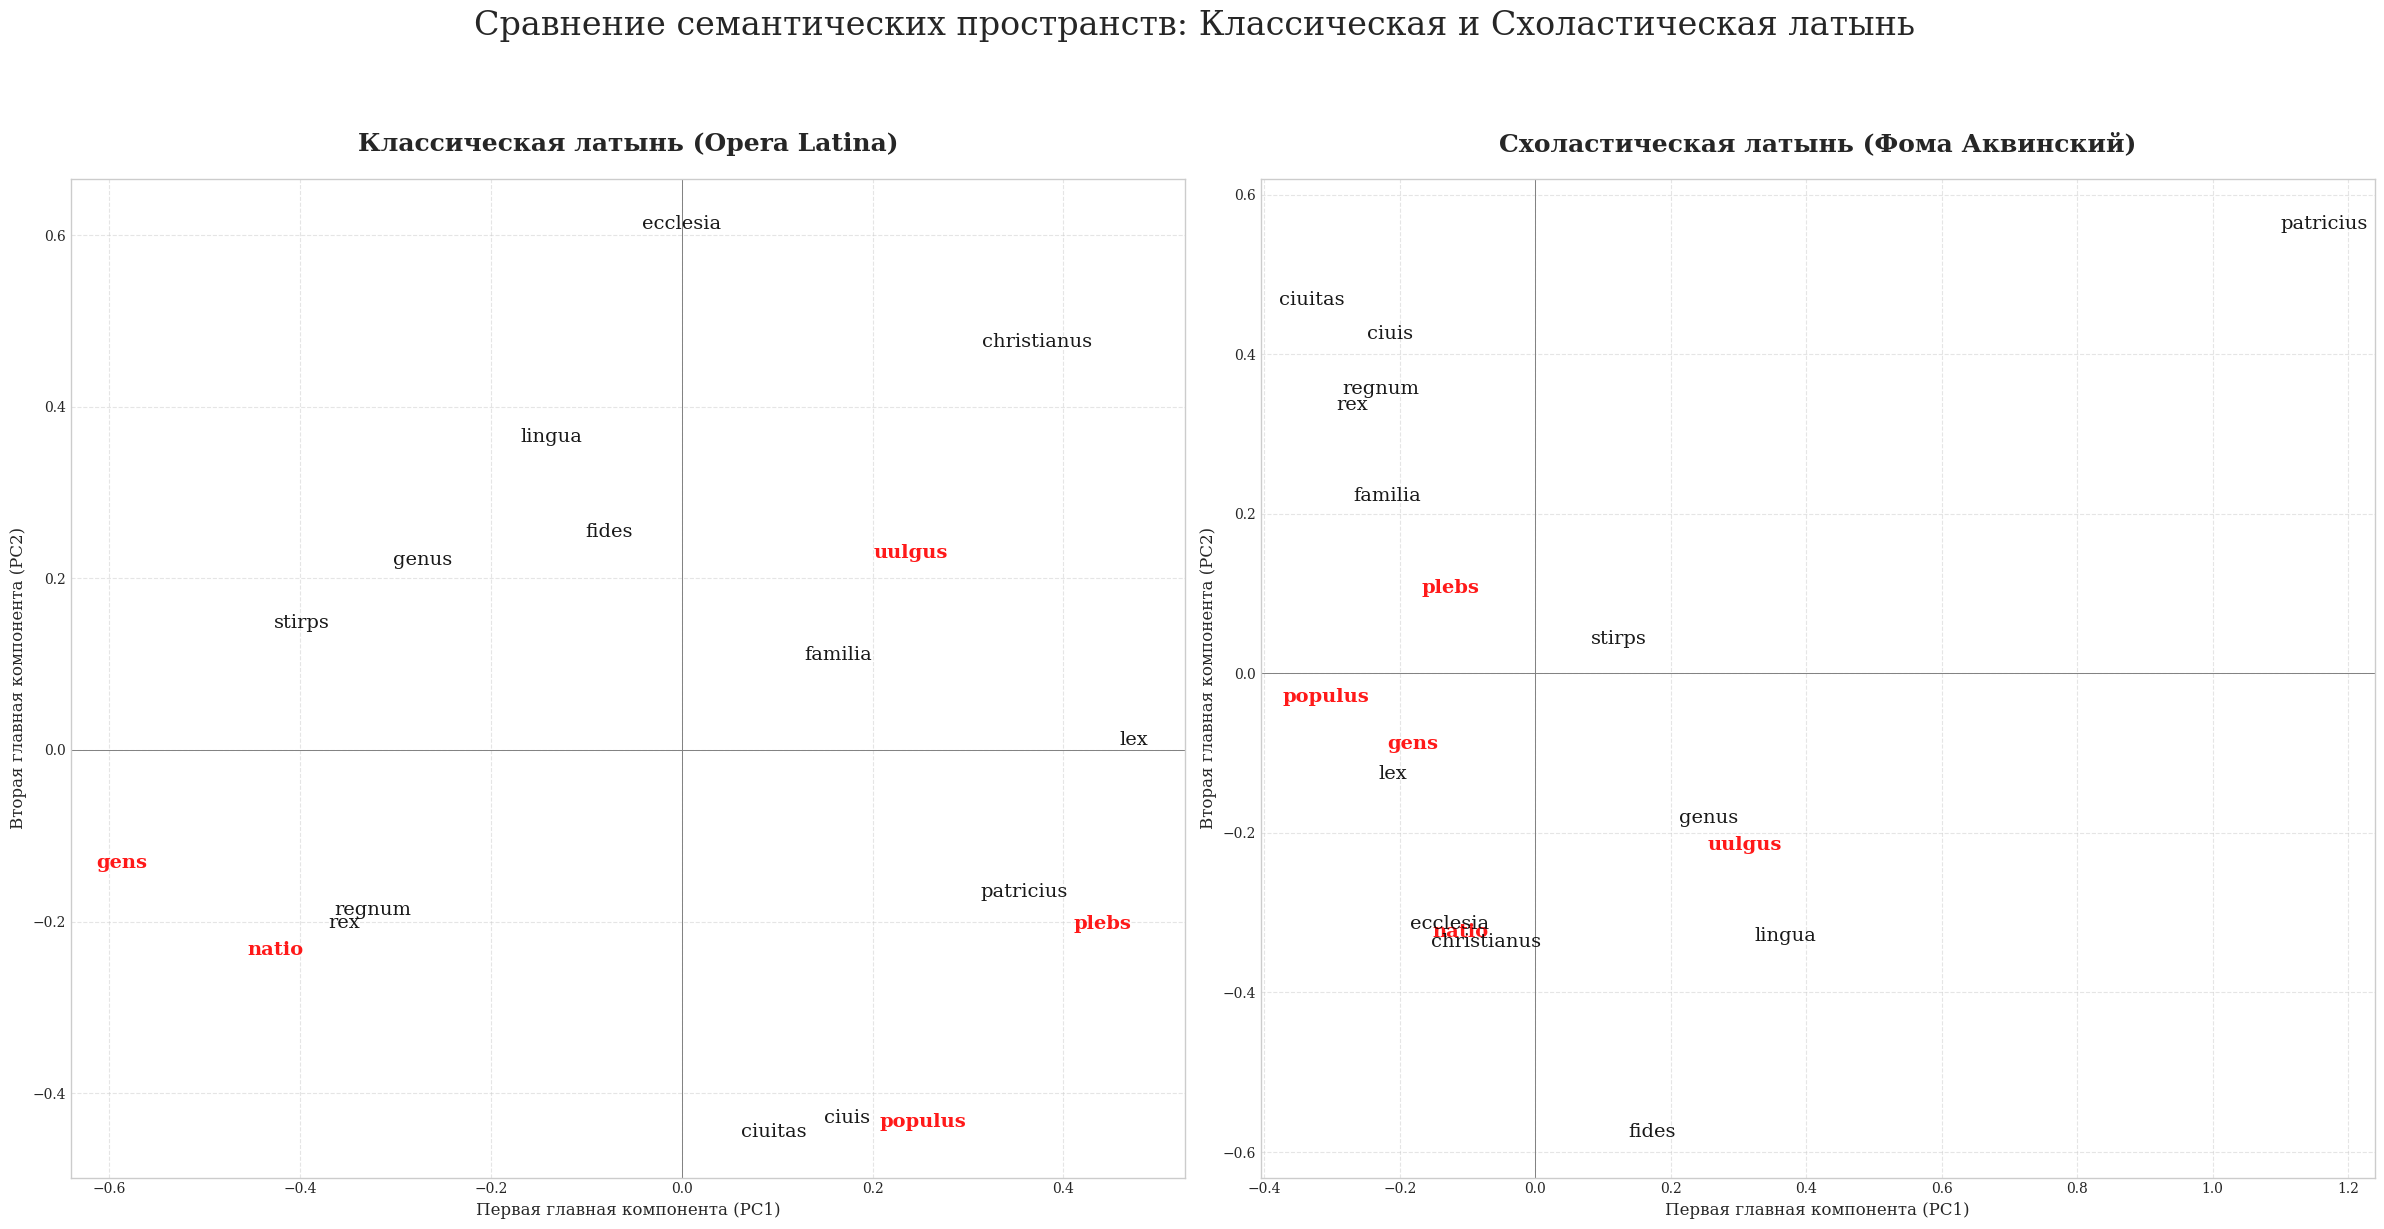

In [8]:
# Ячейка 6: Функция для визуализации и построение графиков

def plot_semantic_space(ax, vectors_2d, words, title, annotations=None):
    """Функция для построения графика семантического пространства с аннотациями."""
    ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0)  # Невидимые точки для масштаба

    # Отображение слов на графике
    for i, word in enumerate(words):
        fontweight = 'bold' if word in main_words else 'normal'
        color = 'red' if word in main_words else 'black'
        ax.text(vectors_2d[i, 0], vectors_2d[i, 1], word,
                ha='center', va='center', fontsize=14,
                fontweight=fontweight, color=color, alpha=0.9)

    # Добавление аннотаций, если они есть
    if annotations:
        for ann in annotations:
            ax.annotate(ann['text'],
                        xy=ann['xy'],
                        xytext=ann['xytext'],
                        fontsize=12,
                        fontstyle='italic',
                        color='blue',
                        arrowprops=dict(facecolor='blue', shrink=0.05, width=1, headwidth=8, alpha=0.6))

    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel("Первая главная компонента (PC1)", fontsize=12)
    ax.set_ylabel("Вторая главная компонента (PC2)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.axhline(0, color='grey', linewidth=0.7)
    ax.axvline(0, color='grey', linewidth=0.7)

# --- Создание сравнительной визуализации ---
if 'vectors_classical_2d' in locals() and 'vectors_aquinas_2d' in locals():
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['font.family'] = 'serif'

    fig, axes = plt.subplots(1, 2, figsize=(24, 12))
    fig.suptitle('Сравнение семантических пространств: Классическая и Схоластическая латынь', fontsize=24, y=1.02)

    # Аннотации для классической модели (координаты подобраны эмпирически)
    annotations_classical = [
        {'text': 'Политико-гражданский кластер', 'xy': (0.1, 0.3), 'xytext': (0.4, 0.4)},
        {'text': 'Этно-родовой кластер', 'xy': (-0.2, -0.2), 'xytext': (-0.6, -0.4)}
    ]

    # Аннотации для модели Фомы Аквинского
    annotations_aquinas = [
        {'text': 'Слияние понятий о "народе"', 'xy': (0, 0.1), 'xytext': (0.3, 0.3)},
        {'text': 'Маргинализация римских понятий', 'xy': (0.4, -0.4), 'xytext': (0.5, -0.6)}
    ]

    # Построение первого графика
    plot_semantic_space(axes[0], vectors_classical_2d, words_classical, 'Классическая латынь (Opera Latina)')

    # Построение второго графика
    plot_semantic_space(axes[1], vectors_aquinas_2d, words_aquinas, 'Схоластическая латынь (Фома Аквинский)')

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()